# DATA PREPROCESSING (for curve fitting assignment)


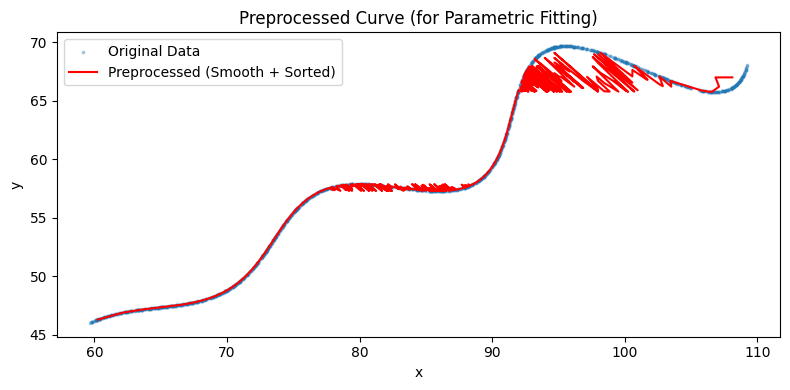

Preprocessed points: 1500
t range: 6.00 → 60.00


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt

df = pd.read_csv("/content/xy_data.csv")
x = df["x"].values
y = df["y"].values

df = df.drop_duplicates(subset=["x", "y"]).reset_index(drop=True)
x, y = df["x"].values, df["y"].values

x_smooth = medfilt(x, kernel_size=5)
y_smooth = medfilt(y, kernel_size=5)

sort_idx = np.argsort(x_smooth + y_smooth)
x_smooth, y_smooth = x_smooth[sort_idx], y_smooth[sort_idx]

dist = np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2)
t = np.concatenate(([0], np.cumsum(dist)))
t = 6 + 54 * (t - t.min()) / (t.max() - t.min())

plt.figure(figsize=(8,4))
plt.scatter(x, y, s=3, alpha=0.3, label="Original Data")
plt.plot(x_smooth, y_smooth, 'r-', linewidth=1.5, label="Preprocessed (Smooth + Sorted)")
plt.title("Preprocessed Curve (for Parametric Fitting)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Preprocessed points: {len(x_smooth)}")
print(f"t range: {t.min():.2f} → {t.max():.2f}")


# EXTENDED PARAMETRIC MODEL + MULTI-START OPTIMIZATION

In [20]:
from scipy.optimize import minimize, least_squares

def model_raw(params, t_):
    theta, M, X, Y0, phi, f, A, a, b, c = params
    tp = a + b * t_ + c * (t_**2)
    x_model = tp * np.cos(theta) - A * np.exp(M * np.abs(tp)) * np.sin(f * tp + phi) * np.sin(theta) + X
    y_model = Y0 + tp * np.sin(theta) + A * np.exp(M * np.abs(tp)) * np.sin(f * tp + phi) * np.cos(theta)
    return x_model, y_model

def l1_loss(params):
    xm, ym = model_raw(params, t)
    return np.sum(np.abs(x_smooth - xm) + np.abs(y_smooth - ym))

def l2_loss(params):
    xm, ym = model_raw(params, t)
    return np.sum((x_smooth - xm)**2 + (y_smooth - ym)**2)

bounds = [
    (0.0, np.deg2rad(50.0)),
    (-0.02, 0.02),
    (0.0, 100.0),
    (0.0, 200.0),
    (-np.pi, np.pi),
    (0.05, 1.5),
    (0.0, 200.0),
    (-50.0, 50.0),
    (0.5, 1.5),
    (-0.01, 0.01)
]

def rand_init():
    return [np.random.uniform(b[0], b[1]) for b in bounds]

best = None
best_l1 = np.inf

for i in range(100):
    p0 = rand_init()
    try:
        res = minimize(l2_loss, p0, method="L-BFGS-B", bounds=bounds, options={'maxiter': 3000})
        if res.success:
            l1v = l1_loss(res.x)
            if l1v < best_l1:
                best = ("L2_local", res.x, l1v)
                best_l1 = l1v
    except Exception:
        pass

if best is not None:
    p0 = best[1]
    def residuals(p):
        xm, ym = model_raw(p, t)
        return np.concatenate([(xm - x_smooth), (ym - y_smooth)])
    try:
        ls = least_squares(residuals, p0, bounds=([b[0] for b in bounds], [b[1] for b in bounds]), loss="soft_l1", max_nfev=10000)
        l1v = l1_loss(ls.x)
        if l1v < best_l1:
            best = ("soft_l1_refine", ls.x, l1v)
            best_l1 = l1v
    except Exception:
        pass

print("Optimization Complete")
print("Best Strategy:", best[0])
print("Best L1 Distance (total):", best[2])
print("Best Parameters (θ, M, X, Y0, φ, f, A, a, b, c):")
print(best[1])

Optimization Complete
Best Strategy: soft_l1_refine
Best L1 Distance (total): 5503.176317662332
Best Parameters (θ, M, X, Y0, φ, f, A, a, b, c):
[ 8.72664626e-01  2.00000000e-02  8.09720104e+01  7.91777736e+01
 -1.68923871e+00  5.00000000e-02  1.89788084e+01 -3.28034276e+01
  1.27239668e+00 -1.00000000e-02]


In [21]:
import numpy as np
from scipy.optimize import minimize, least_squares

# Ensure model_raw, l1_loss, l2_loss, bounds, rand_init are defined or accessible
# (Assuming they are already defined in a previous cell and are in the global scope)

best_new = None
best_l1_new = np.inf

# Increase multi-start attempts to 200
for i in range(200):
    p0 = rand_init()
    try:
        res = minimize(l2_loss, p0, method="L-BFGS-B", bounds=bounds, options={'maxiter': 3000})
        if res.success:
            l1v = l1_loss(res.x)
            if l1v < best_l1_new:
                best_new = ("L2_local", res.x, l1v)
                best_l1_new = l1v
    except Exception:
        pass

if best_new is not None:
    p0 = best_new[1]
    def residuals(p):
        xm, ym = model_raw(p, t)
        return np.concatenate([(xm - x_smooth), (ym - y_smooth)])
    try:
        # Increase max_nfev for least_squares to 20000
        ls = least_squares(residuals, p0, bounds=([b[0] for b in bounds], [b[1] for b in bounds]), loss="soft_l1", max_nfev=20000)
        l1v = l1_loss(ls.x)
        if l1v < best_l1_new:
            best_new = ("soft_l1_refine", ls.x, l1v)
            best_l1_new = l1v
    except Exception:
        pass

print("Optimization Complete (New Run)")
print("Best Strategy:", best_new[0] if best_new else "N/A")
print("Best L1 Distance (total):", best_new[2] if best_new else "N/A")
print("Best Parameters (θ, M, X, Y0, φ, f, A, a, b, c):")
print(best_new[1] if best_new else "N/A")

# Compare with previous best, if available
if 'best' in globals() and best_new and best_new[2] < best[2]:
    print(f"\nImproved L1 Distance from previous run: {best[2]:.6f} to {best_new[2]:.6f}")
elif 'best' in globals() and best_new:
    print(f"\nL1 Distance did not improve from previous run: {best[2]:.6f} vs {best_new[2]:.6f}")
else:
    print("\nNo previous best result to compare with.")

# Update global 'best' if the new run is better
if best_new and ('best' not in globals() or best_new[2] < best[2]):
    best = best_new
    print("Global 'best' variable updated with new result.")

Optimization Complete (New Run)
Best Strategy: soft_l1_refine
Best L1 Distance (total): 5503.175303684376
Best Parameters (θ, M, X, Y0, φ, f, A, a, b, c):
[ 8.72664626e-01  2.00000000e-02  8.09722332e+01  7.91776867e+01
 -1.68923997e+00  5.00000000e-02  1.89786227e+01 -3.28034965e+01
  1.27239617e+00 -1.00000000e-02]

Improved L1 Distance from previous run: 5503.176318 to 5503.175304
Global 'best' variable updated with new result.


# DIAGNOSTICS & FINAL L1 EVALUATION

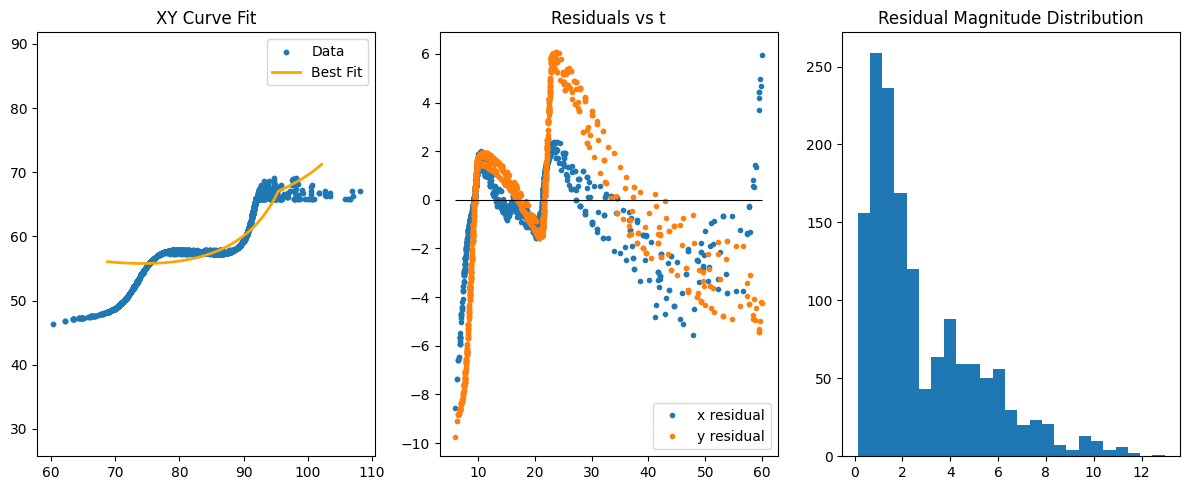

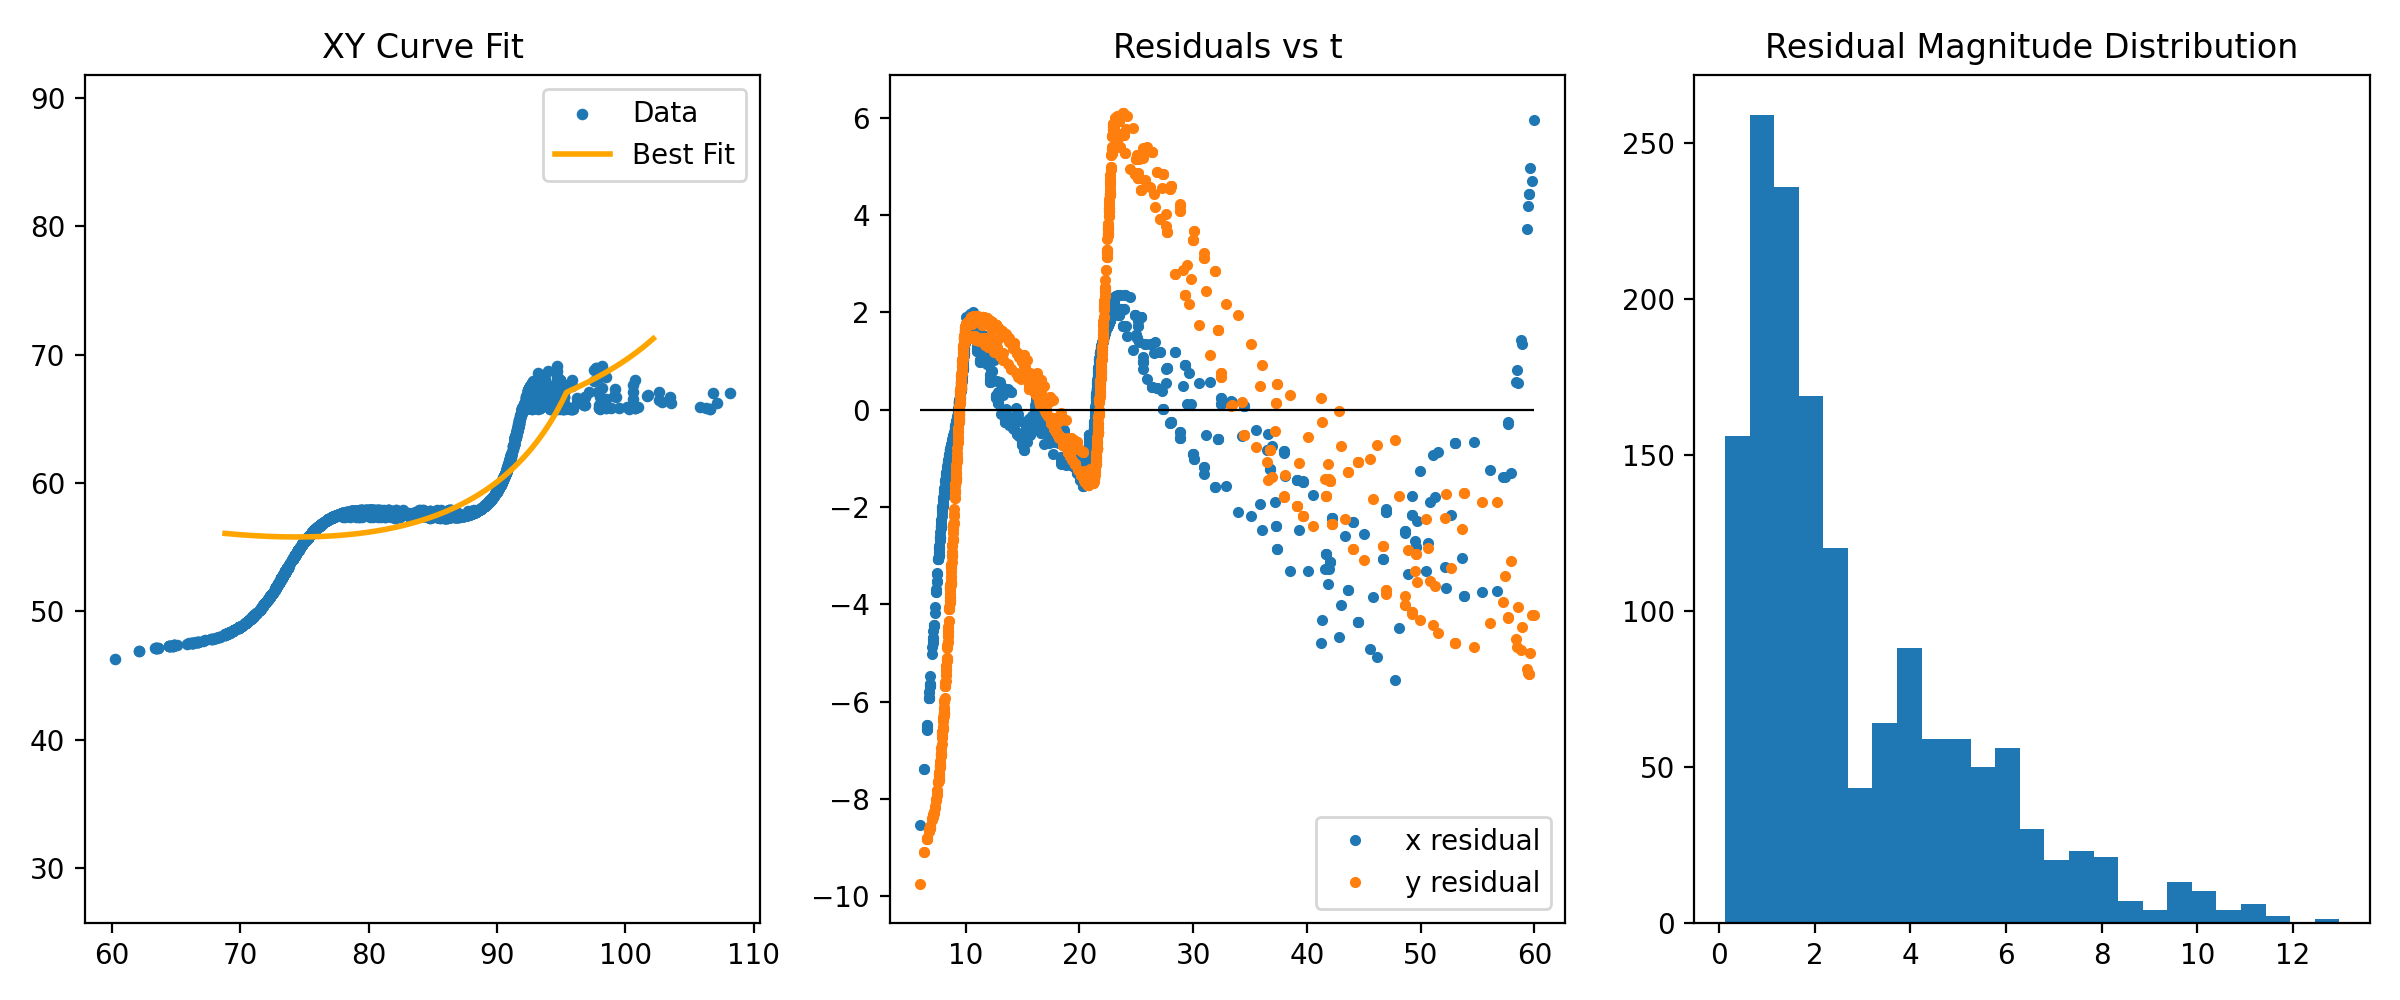

L1 Distance (Total): 5503.175304
L1 Distance (Average per sample): 3.668784
Final Parameters:
[ 8.72664626e-01  2.00000000e-02  8.09722332e+01  7.91776867e+01
 -1.68923997e+00  5.00000000e-02  1.89786227e+01 -3.28034965e+01
  1.27239617e+00 -1.00000000e-02]


In [22]:
from IPython.display import Image

best_params = best[1]
xm, ym = model_raw(best_params, t)


l1_total = np.sum(np.abs(xm - x_smooth) + np.abs(ym - y_smooth))
l1_avg = l1_total / len(t)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(x_smooth, y_smooth, s=10, label="Data")
plt.plot(xm, ym, "-", color="orange", linewidth=2, label="Best Fit")
plt.axis("equal")
plt.legend()
plt.title("XY Curve Fit")

plt.subplot(1, 3, 2)
plt.plot(t, x_smooth - xm, ".", label="x residual")
plt.plot(t, y_smooth - ym, ".", label="y residual")
plt.hlines(0, t.min(), t.max(), colors="k", linewidth=0.8)
plt.legend()
plt.title("Residuals vs t")

plt.subplot(1, 3, 3)
res_mag = np.sqrt((x_smooth - xm)**2 + (y_smooth - ym)**2)
plt.hist(res_mag, bins=25)
plt.title("Residual Magnitude Distribution")

plt.tight_layout()
plt.savefig("final_fit_plot.png", dpi=200)
plt.show()
display(Image("final_fit_plot.png"))

print(f"L1 Distance (Total): {l1_total:.6f}")
print(f"L1 Distance (Average per sample): {l1_avg:.6f}")
print("Final Parameters:")
print(best_params)